## Índice

0. Introducción

 - Funciones 
 - Base de datos
 - Preprocesado y comprobación de missing values (NaN)

Para un país:España.

1. Series temporales: AR, ARMA, ARIMA
2. Series temporales: VAR
3. Ajustes de curva de vacunación: lineal, potencia, cuadrática, exponencial y logística

Para Un continente: Europa.

4. Series temporales: AR, ARMA, ARIMA
5. Series temporales: VAR
6. Ajustes de curva de vacunación: lineal, potencia, cuadrática, exponencial y logística

In [108]:
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Funciones

In [109]:
def preprocesado_pais(covid_vaccine_data,pais):
    """
    covid_vaccine_data: dataframe con todas las vacunas
    pais: pais que queremos escoger para analizar
    """
    vacc_pais = covid_vaccine_data.loc[covid_vaccine_data.country == pais]
    #print(pais)
    vacc_pais.set_index('date',inplace=True)
    
    
    #crear una funcion de preprocesado
    vacc_pais['daily_vaccinations']= vacc_pais['daily_vaccinations'].interpolate(method='cubicspline')
    vacc_pais['total_vaccinations']= vacc_pais['total_vaccinations'].interpolate(method='cubicspline')
    vacc_pais['people_vaccinated']= vacc_pais['people_vaccinated'].interpolate(method='cubicspline')

    vacc_pais['people_fully_vaccinated']= vacc_pais['people_fully_vaccinated'].interpolate(method='cubicspline')
    vacc_pais['total_vaccinations_per_hundred']= vacc_pais['total_vaccinations_per_hundred'].interpolate(method='cubicspline')
    vacc_pais['people_vaccinated_per_hundred']= vacc_pais['people_vaccinated_per_hundred'].interpolate(method='cubicspline')

    vacc_pais['people_fully_vaccinated_per_hundred']=vacc_pais['people_fully_vaccinated_per_hundred'].interpolate(method='cubicspline')
    vacc_pais['daily_vaccinations_per_million']= vacc_pais['daily_vaccinations_per_million'].interpolate(method='cubicspline')

    vacc_pais = vacc_pais.fillna(vacc_pais.median())
    
    vacc_pais["date"] = vacc_pais.index
    vacc_pais["Days"]=vacc_pais.date - vacc_pais.date.min()
    vacc_pais["Days"]=vacc_pais["Days"].dt.days
    
    population = vacc_pais["Population"][1]
    vacc_pais['percentage_vaccinated'] = (vacc_pais.people_fully_vaccinated/population)*100
    
    return vacc_pais

### Base de datos

Cargamos la base de datos que obtenemos del otro cuaderno jupyter: 'covid_vaccine_data.csv'

In [110]:
covid_vaccine_data = pd.read_csv('covid_vaccine_data.csv')

covid_vaccine_data['date'] = pd.to_datetime(covid_vaccine_data['date'])
covid_vaccine_data['date'] = covid_vaccine_data['date'].dt.strftime('%Y-%m-%d')
covid_vaccine_data[['date']] = covid_vaccine_data[['date']].apply(pd.to_datetime)

#PARSEAMOS Y NOS QUEDAMOS CON LOS DATOS DE ESPAÑA
vacc_Spain = preprocesado_pais(covid_vaccine_data,'Spain')
vacc_Spain.shape

(122, 20)

In [111]:
print('El rango que nuestros datos abarcan es de',len(covid_vaccine_data.date.unique()),'días de vacunación')

El rango que nuestros datos abarcan es de 144 días de vacunación


### Comprobación de missing values.

Nos aseguramos de que no tenemos ningún NaN para que no haya problemas al construir nuestros modelos:

In [112]:
vacc_Spain.isnull().sum()

Unnamed: 0                             0
iso_code                               0
country                                0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
Population                             0
Full_vaccinations(count)               0
Total_vaccinations(count)              0
date                                   0
Days                                   0
percentage_vaccinated                  0
dtype: int64

Está todo en orden, no hay NaN.

# Estimación en un país: España

## 1. Series temporales univariable: AR, ARMA, ARIMA

En esta sección nos vamos a centrar en los métodos **AR** (modelo autorregresivo), **ARMA** (autorregresivo de media móvil) y **ARIMA** (modelo autorregresivo integrado de media móvil). 

Son modelos estadístico que utiliza variaciones y regresiones de datos estadísticos para encontrar patrones para una predicción en el futuro. Se trata de un modelos dinámico de series temporales, es decir, las **estimaciones futuras se explican por los datos pasados**.

A continuación vamos a crear tres modelos con la finalidad de comprobar cuál es el más adecuado para predecir los datos de 'vacunaciones totales' y de 'gente totalmente vacunada' futuros en un horizonte de 7 días. 

Para ello nos centraremos en las variables:
 - *'people_fuly_vaccinated'*
 - *'total_vaccinations'* 
 
 del dataframe **vacc_Spain**.

In [164]:
#vacc_Spain.total_vaccinations

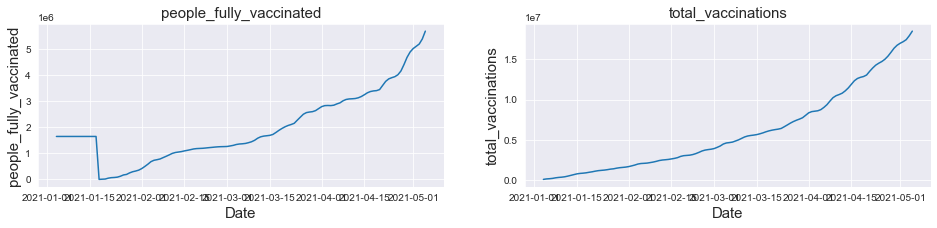

In [166]:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.title('people_fully_vaccinated')
sns.lineplot(data=vacc_Spain['people_fully_vaccinated'])
#sns.lineplot(data = vacc_Spain['daily_vaccinations'])
plt.title('people_fully_vaccinated',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('people_fully_vaccinated', fontsize=15)

plt.subplot(122)
plt.title('total_vaccinations')
sns.lineplot(data=vacc_Spain['total_vaccinations'])
#sns.lineplot(data = vacc_Spain['daily_vaccinations'])
plt.title('total_vaccinations',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.ylabel('total_vaccinations', fontsize=15)
plt.show()


### Media semanal y mensual

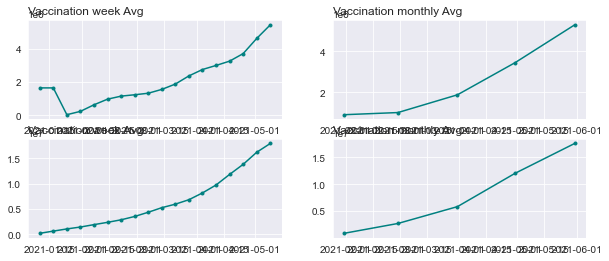

In [177]:
vacc_weekly_avg = vacc_Spain.resample('W').apply(np.mean)
vacc_monthly_avg = vacc_Spain.resample('M').apply(np.mean)

plt.figure(figsize=(10,4))
plt.subplot(221)
plt.title('Vaccination week Avg', loc='left')

plt.plot(vacc_weekly_avg.people_fully_vaccinated, "-o", markersize=3, color='teal')
plt.subplot(222)
plt.title('Vaccination monthly Avg', loc='left')
plt.plot(vacc_monthly_avg.people_fully_vaccinated, "-o", markersize=3, color='teal')

plt.subplot(223)
plt.title('Vaccination week Avg', loc='left')
plt.plot(vacc_weekly_avg.total_vaccinations, "-o", markersize=3, color='teal')
plt.subplot(224)
plt.title('Vaccination monthly Avg', loc='left')
plt.plot(vacc_monthly_avg.total_vaccinations, "-o", markersize=3, color='teal')
plt.show()

Otra forma de capturar la tendencia es a través de la media móvil que haremos a continuación. Básicamente tomamos una ventana de puntos de datos consecutivos, en nuestro caso se trata de una frecuencia diaria, calculamos la media de los mismos, y sustituimos toda la ventana por esa media, ya sea en el extremo derecho o en el centro de la ventana. Así que la ventana de 7 es lo mismo que la media semanal:

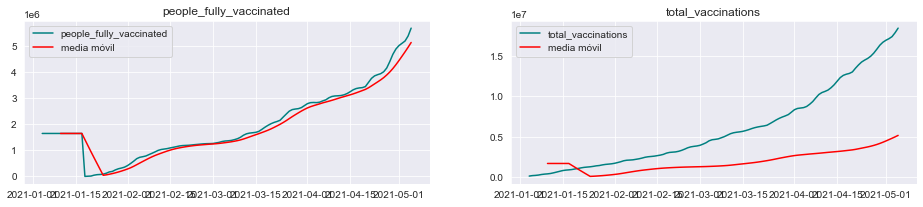

In [178]:
rolling_mean = vacc_Spain.people_fully_vaccinated.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(16,3))
plt.subplot(121)
plt.plot(vacc_Spain.people_fully_vaccinated, color='teal', label = 'people_fully_vaccinated')
plt.plot(rolling_mean, 'red',label = 'media móvil')
plt.title('people_fully_vaccinated')
plt.legend()

plt.subplot(122)
plt.plot(vacc_Spain.total_vaccinations, color='teal', label = 'total_vaccinations')
plt.plot(rolling_mean, 'red',label = 'media móvil')
plt.title('total_vaccinations')
plt.legend()

### Datos  estacionarios y la autocorrelación¶

Tras algunas exploraciones iniciales, ha llegado el momento de crear nuestro modelo. Para ello, primero tenemos que hacer que la serie sea estacionaria, ya que es un requisito previo para la mayoría de los modelos. Hacer que los datos sean estacionarios significa quitarles la tendencia (quitarles la tendencia a los datos) para que sus propiedades estadísticas (es decir, la media y la varianza) sean constantes a lo largo del tiempo. Esto ayudará a que la muestra sea más predecible para el modelo, ya que se puede suponer que las propiedades estadísticas de los datos serán las mismas en el futuro que en el pasado. Una forma de estacionar una serie temporal es mediante la diferenciación, es decir, tomando la diferencia de dos puntos de datos dentro de un periodo determinado, este periodo se denomina **retardo** (lag) .

Para encontrar el **lag** óptimo utilizamos el método de autocorrelación.


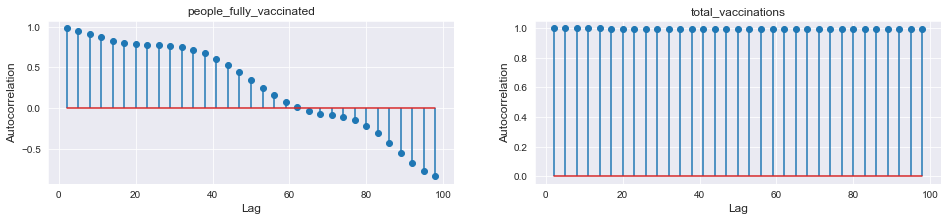

In [188]:
#lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180]
lags = np.arange(2,100,3)
autocorrs_fully_vaccinated = [vacc_Spain.people_fully_vaccinated.autocorr(lag=lag) 
                   for lag in lags]


plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.stem(lags, autocorrs_fully_vaccinated)
plt.title('people_fully_vaccinated')
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

autocorrs_total = [vacc_Spain.total_vaccinations.autocorr(lag=lag) 
                   for lag in lags]
plt.subplot(122)
plt.stem(lags, autocorrs_total)
plt.title('total_vaccinations')
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

plt.show()

Según el gráfico anterior, la mayor correlación se produce con un desfase de 2, lo que significa que los datos repiten un patrón semanalmente.

Text(0.5, 1.0, 'people_fully_vaccinated')

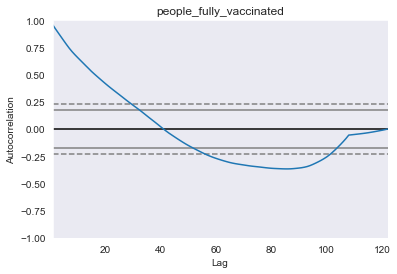

In [200]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(vacc_Spain['people_fully_vaccinated'])
plt.title('people_fully_vaccinated')

Text(0.5, 1.0, 'total_vaccinations')

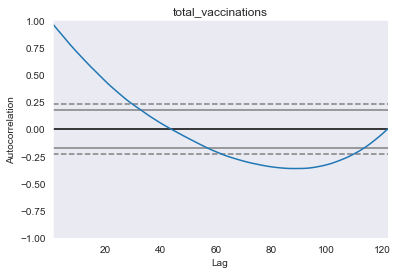

In [201]:
autocorrelation_plot(vacc_Spain['total_vaccinations'])
plt.title('total_vaccinations')

Podemos concluir que un desfase de 2 es un buen candidato para el desfase óptimo. Vamos a trazar la serie original frente a la versión retardada de la misma con una diferencia de 2. Esto significa que cada punto de datos (a partir del 2º) se deducirá de los datos de 7 días anteriores y se trazará en el gráfico (línea naranja inferior).

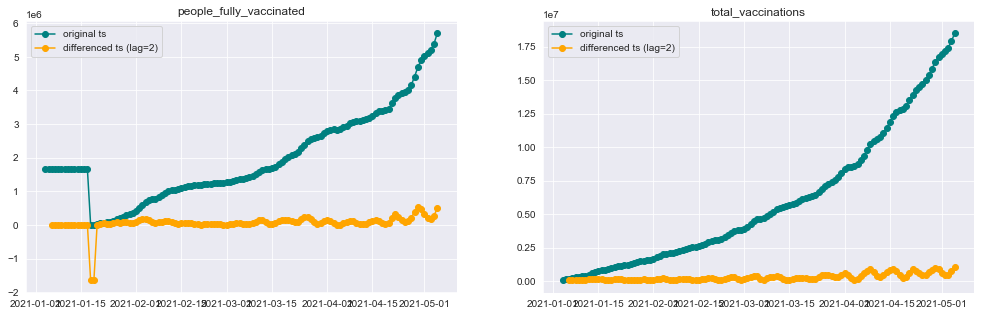

In [207]:
#people_fully_vaccinated
plt.figure(figsize=(17, 5))
plt.subplot(121)
plt.plot(vacc_Spain.people_fully_vaccinated, '-o', color='teal', label="original ts")
plt.plot(vacc_Spain.people_fully_vaccinated.diff(2), '-o', color='orange', label="differenced ts (lag=2)")
plt.title('people_fully_vaccinated')
plt.legend(fontsize=10)
plt.subplot(122)
plt.plot(vacc_Spain.total_vaccinations, '-o', color='teal', label="original ts")
plt.plot(vacc_Spain.total_vaccinations.diff(2), '-o', color='orange', label="differenced ts (lag=2)")
plt.title('total_vaccinations')
plt.legend(fontsize=10)

## Developing the models


Text(0.5, 1.0, 'People fully vaccinated')

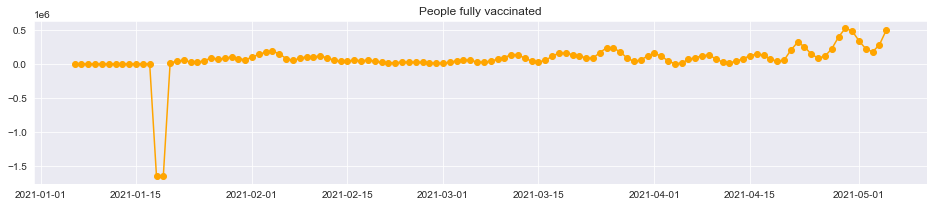

In [124]:
people_fully_vaccinated = vacc_Spain.people_fully_vaccinated

people_fully_vaccinated_diff =people_fully_vaccinated.diff(2)

plt.figure(figsize=(16,3))
plt.plot(people_fully_vaccinated_diff, "-o", color='orange')
plt.title('People fully vaccinated')

La figura anterior parece lo suficientemente estacionaria, por lo que se elige optlag=2 para las siguientes operaciones

Para empezar, guardemos los **datos estacionarios** en una nueva variable y llamémosla time_series:

In [125]:
time_series = people_fully_vaccinated_diff


##  linearRegression and then AR and ARMA models (univariables) (time_series has not changed still diff=2)


Para la regresión lineal sobre series temporales necesitamos organizar los datos con la matriz X donde cada fila contiene un viento de previsión e y son los valores objetivo para cada fila de X.

In [126]:
time_series

date
2021-01-04              NaN
2021-01-05              NaN
2021-01-06         0.000000
2021-01-07         0.000000
2021-01-08         0.000000
                  ...      
2021-05-01    336887.127638
2021-05-02    219394.145980
2021-05-03    175643.872362
2021-05-04    280717.000000
2021-05-05    494530.000000
Name: people_fully_vaccinated, Length: 122, dtype: float64

In [127]:
#time_series
time_series = time_series.fillna(time_series.median())

In [128]:
#SPLIT de train y test
split_point = len(time_series) - 10
dataset, validation = time_series[0:split_point], time_series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 112, Validation 10


In [129]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 2
X, y = organize_data(np.array(time_series), lag)

#### Regresión lineal

MAE = 64323.230
MAE2 = 39729.561


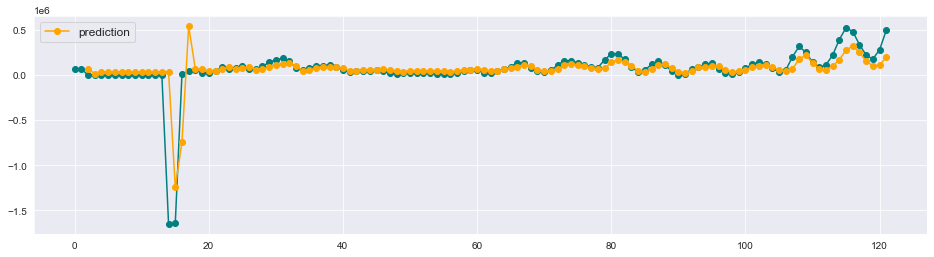

In [130]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

lr_mse = mean_squared_error(y,lr_prediction)
#print('Mean squared error:', lr_mse)

plt.figure(figsize=(16, 4))
plt.plot(time_series.values, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], lr_prediction[-90:]))) #for the last 90 days only

### AR Model


**AR** significa modelo de serie temporal autorregresivo, en el que los valores se modelan como una combinación lineal de los p valores pasados, por lo que se indica como AR(p).
p define el número de observaciones pasadas que queremos que el modelo utilice para predecir los próximos datos y también se conoce como el orden de retardo.

Podemos utilizar el método select_order para encontrar el valor óptimo de **p** como se indica a continuación, tenga en cuenta que tendrá que definir maxlag que es la mayor longitud de lag que se va a probar. **ic** es el criterio utilizado para seleccionar el lag óptimo. [docs] (http://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit) and see how those perform. I found 'aic' better for this task.


In [131]:
import warnings 
warnings.filterwarnings("ignore")

#planteamos el modelo AR
ar = tsa.AR(time_series)
#calculamos cual es el lag o el desfase adecuado 

optlag = ar.select_order(60, ic='aic') 
print("Best optimal lag for ar model: {}".format(optlag))

Best optimal lag for ar model: 3


Optimal lag for AR model: 3

Optimal p value seems to be 3 days, having that we can train our model and see how it performs using mean absolute error (MAE) or mean of the residuals which is calculated as below, where y and x are predicted versus actual values per observation:

I am also printing out MAE_2 which is the mean absolute error only for the last 90 predictions as a fixed set to compare the results of this model with ARMA model later on.


In [132]:
len(time_series)

122

MAE = 60480.156
MAE2 = 36268.888


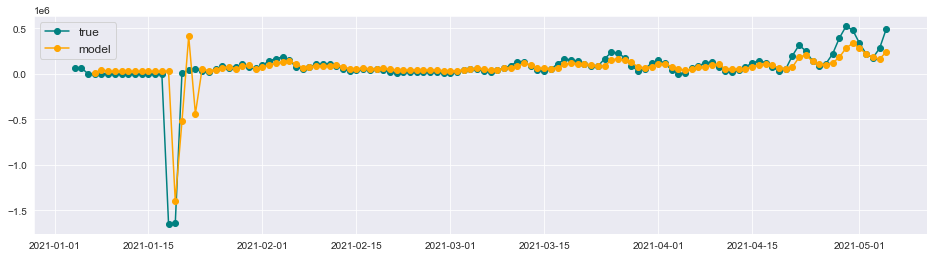

In [133]:
lag = 3 
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], ar_prediction[-90:]))) #error only for the last 90 days

Vemos que el modelo se adapta bien a los datos.

### ARMA model

ARMA stands for Autoregressive Moving Average. The difference between ARMA and AR is that the latter models a point in the time series as a linear model of the previous values, and treats the error between the actual data and the predictions as noise. But what if there could still be information in the series of errors? ARMA on the other hand includes the past errors as additional features to the model and is defined as ARMA(p,q).

Just as the name suggests ARMA is comprised of two models, AR(p) (just like above) and MA(q) which is the moving average part and q defines the number of moving average terms.
Let's now run the model with p=7 and q=7 and see the results. You should also play around with these two variables and see the different results that they produce.


In [134]:
#time_series = np.array(time_series)

# Autoregressive Moving Average ARMA

MAE = 76779.96
MAE2 = 97927.76


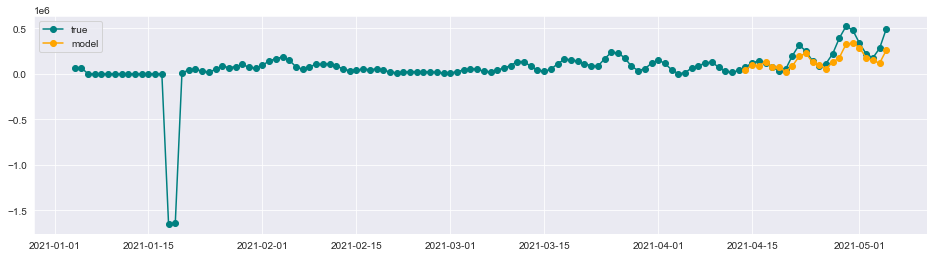

In [135]:
arma = tsa.ARMA(time_series, order=(2, 1)) #2 p and 1 q for lag and moving average 
arma_fit = arma.fit()
start=100
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.2f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.2f}'.format(mean_absolute_error(time_series[-13:], arma_prediction[-13:]))) #error only for the last 90 days



### Predicción fuera de la muestra (los próximos 7 días)

Hasta ahora hemos entrenado los modelos con los datos existentes y hemos evaluado su rendimiento comprobando el error medio absoluto de las predicciones frente a los valores reales. Ahora que tenemos dos modelos entrenados, vamos a utilizarlos para predecir los valores futuros (fuera de muestra).

Dado que nuestro modelo **AR** produjo un error menor, primero lo utilizaré para predecir el futuro y luego seguiré los mismos pasos para predecir el precio con los modelos **ARMA** y luego con los **ARIMA**.

Usando el mismo lag óptimo de 13, predecimos 7 valores fuera de muestra. El argumento final de la función predecir, es donde definimos el índice de la última predicción que queremos predecir. Esto para 7 predicciones fuera de muestra será la longitud de la serie + 6.


In [136]:
#7 out of sample prediction with AR 
lag = 9
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-7:] 
ar_forecast

2021-05-06    409293.911885
2021-05-07    220483.238335
2021-05-08    191246.196509
2021-05-09    184818.653319
2021-05-10    186263.090510
2021-05-11    189277.184347
2021-05-12    176634.147450
Freq: D, dtype: float64

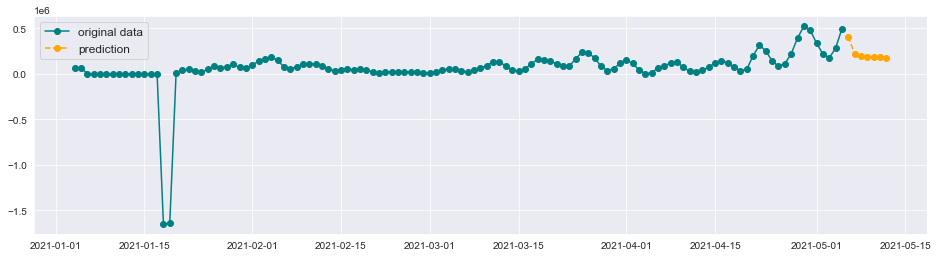

In [137]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [138]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(2, 1)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-7:]
arma_forecast

2021-05-06    364840.795653
2021-05-07    131435.001641
2021-05-08     95188.540036
2021-05-09     73379.496334
2021-05-10     68162.089668
2021-05-11     65917.178762
2021-05-12     65267.355913
Freq: D, dtype: float64

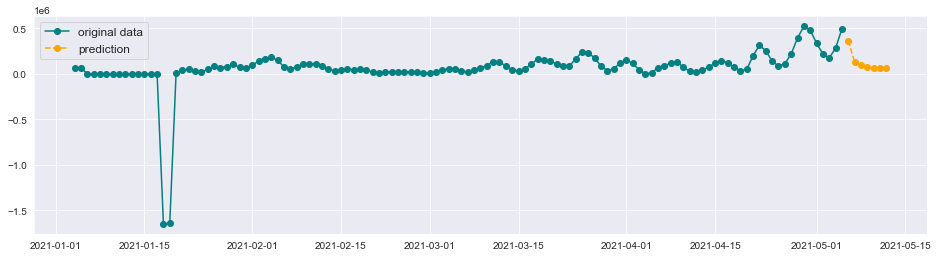

In [139]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [140]:
#and here ARIMA which is basically same thing as ARMA but in a slightly different implementation.
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(2,1,1))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

array([399698.78102207, 259269.18659091, 193733.58551997, 197533.1361955 ,
       224754.61266506, 244558.82109164, 250914.83612066])

Lo que hemos predicho no son los precios futuros reales, sino los **valores diferenciados**. ¿Recuerdas que inicialmente hicimos estacionarios los datos diferenciándolos con un retardo de 7? Ahora, para encontrar los precios futuros reales, tenemos que invertir el proceso y cambiar la serie de estacionaria a la forma original. Para ello, añadimos cada valor previsto al valor real de los 7 días anteriores. Los valores de los últimos 7 días en la serie original eran:

In [141]:
print(people_fully_vaccinated[-7:]) #the actual last 7 sample daily_vaccinations

date
2021-04-29    4.689766e+06
2021-04-30    4.894204e+06
2021-05-01    5.026653e+06
2021-05-02    5.113598e+06
2021-05-03    5.202297e+06
2021-05-04    5.394315e+06
2021-05-05    5.696827e+06
Name: people_fully_vaccinated, dtype: float64


Una vez hecho esto, calculamos los valores reales de las 7 predicciones fuera de la muestra y los representamos con el resto de la serie:

In [142]:
idx = ar_forecast.index.values

forecast_people_fully_vaccinated = []
lag = 7
for i, diff in enumerate(ar_forecast): #choosing AR as it produced lower MAE than ARMA model
    prev_value = people_fully_vaccinated[-(lag)+i:][0]
    forecast_people_fully_vaccinated.append(prev_value+diff)
    
people_fully_vaccinated_forecast = pd.Series(forecast_people_fully_vaccinated, index=idx)
people_fully_vaccinated_forecast

2021-05-06    5.099060e+06
2021-05-07    5.114687e+06
2021-05-08    5.217899e+06
2021-05-09    5.298417e+06
2021-05-10    5.388560e+06
2021-05-11    5.583592e+06
2021-05-12    5.873461e+06
dtype: float64

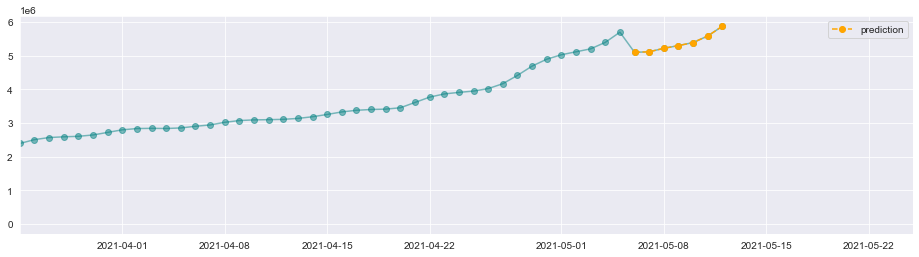

In [143]:
hist_values = vacc_Spain['people_fully_vaccinated'].append(people_fully_vaccinated_forecast)

plt.figure(figsize=(16,4))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.plot(people_fully_vaccinated_forecast, '--o', label='prediction', color='orange')
plt.legend()

plt.xlim('2021-03-25','2021-05-25')
plt.show()

In [144]:
#vacc_Spain.T

# VAR (Vector Autoregressions) Multivariable

In [145]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [146]:
#vacc_Spain.T

In [147]:
#vacc_Spain.T

variables = ['total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations']

In [148]:
var_Spain = vacc_Spain[variables]
var_Spain.head(5)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
date,,,,
2021-01-04,82834.000000,82834.000000,1.651468e+06,102279.0
2021-01-05,139339.000000,139339.000000,1.651468e+06,56505.0
2021-01-06,167094.453549,167094.366452,1.651468e+06,45248.0
2021-01-07,207323.000000,207323.000000,1.651468e+06,41496.0
2021-01-08,277976.000000,277976.000000,1.651468e+06,48786.0


In [149]:
#con vacc_Spain
model_var = VAR(var_Spain)

In [150]:
results = model_var.fit(2)

In [151]:
#results.summary()

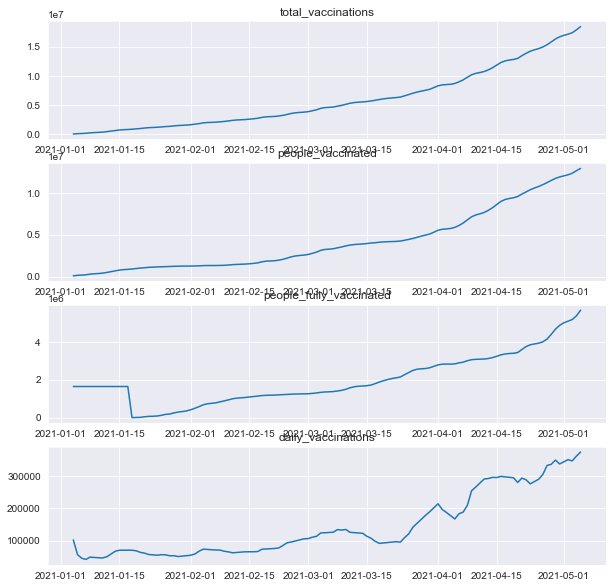

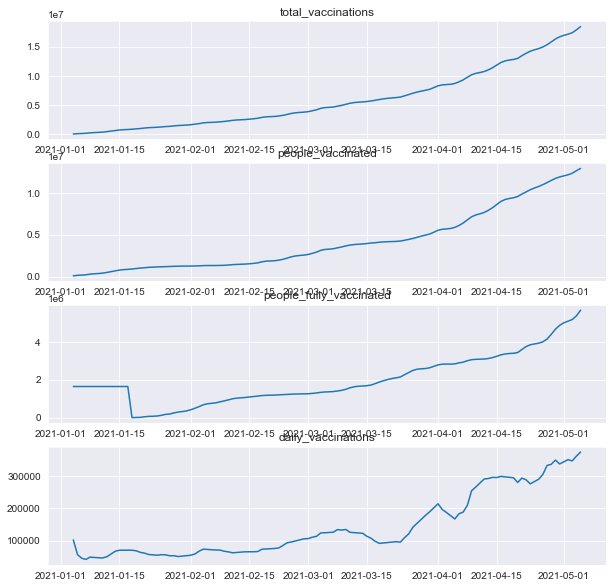

In [152]:
results.plot()

In [153]:
#results.plot_acorr()

#### Lag order selection

In [154]:
#model_var.select_order(15)

In [155]:
results = model_var.fit(maxlags=23, ic='aic')

In [156]:
lag_order = results.k_ar
print(lag_order)

23


El predictor lineal es la previsión óptima de un paso adelante en términos de error cuadrático medio. Ya va implementado en el algoritmo. 

In [157]:
results.forecast(var_Spain.values[-lag_order:], 20)

array([[19628238.93772848, 13729479.18188292,  6100850.37404494,
          477399.79857498],
       [20816894.70047975, 14393141.32789194,  6651778.50864225,
          608840.36911598],
       [21990674.70820176, 15018039.27697842,  7199883.09592605,
          700968.84566177],
       [23193610.34544852, 15832280.92091117,  7594376.68254656,
          831895.88318597],
       [24087659.41993327, 16462903.01731998,  7876156.13236191,
          957446.15209872],
       [24878680.65218776, 17011468.49835134,  8150155.14427107,
          985818.93433707],
       [26293325.22223122, 18062730.432285  ,  8506547.54737   ,
         1114133.0397876 ],
       [27675588.66363068, 19111928.35531438,  8824166.93126855,
         1127870.48690425],
       [28603236.75314939, 19875260.90016757,  9026172.15702388,
         1074662.08604916],
       [29388616.75768892, 20398604.95232205,  9331940.81784775,
         1099651.2852631 ],
       [29732341.51105385, 20485227.46872494,  9569751.76501889,
     

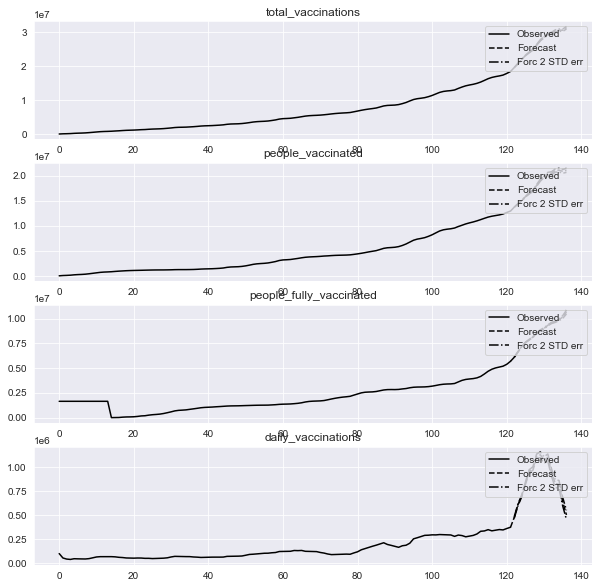

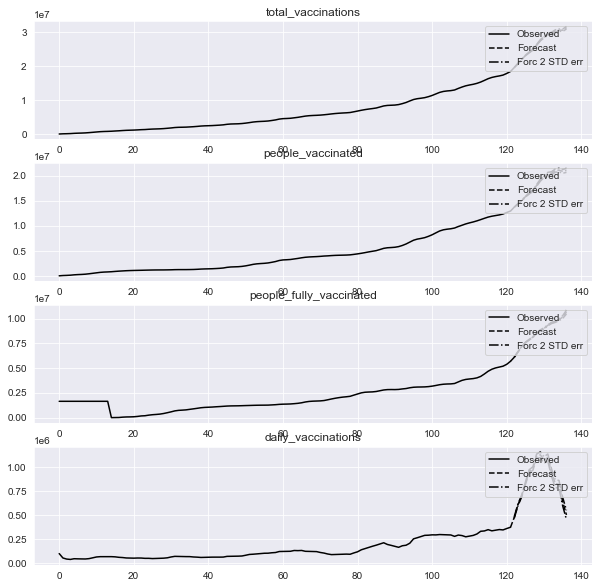

In [158]:
#
results.plot_forecast(15)

**Importante incluir una medida de prestación para el VAR** 
https://www.statsmodels.org/dev/vector_ar.html#post-estimation-analysis

La autorregresión vectorial (VAR) es un algoritmo de previsión multivariante que se utiliza cuando dos o más series temporales se influyen mutuamente.

Es decir, los requisitos básicos para utilizar el VAR son:
- Se necesitan al menos dos series temporales (variables)
- Las series temporales deben influirse mutuamente.

Bien, ¿en qué se diferencia el VAR de otros modelos autorregresivos como AR, ARMA o ARIMA?

La principal diferencia es que esos modelos son unidireccionales, es decir, los predictores influyen en Y y no a la inversa. En cambio, la autorregresión vectorial (VAR) es bidireccional. Es decir, las variables se influyen mutuamente. 

En el modelo VAR, cada variable se modela como una combinación lineal de los valores pasados de sí misma y de los valores pasados de otras variables del sistema. Dado que tiene múltiples series temporales que se influyen mutuamente, se modela como un sistema de ecuaciones con una ecuación por variable (serie temporal).

Es decir, si tiene 5 series temporales que se influyen mutuamente, tendremos un sistema de 5 ecuaciones.

The procedure to build a VAR model involves the following steps:

    1. Analyze the time series characteristics
    2. Test for causation amongst the time series
    3. Test for stationarity
    4. Transform the series to make it stationary, if needed
    5. Find optimal order (p)
    6. Prepare training and test datasets
    7. Train the model
    8. Roll back the transformations, if any.
    9. Evaluate the model using test set
    10. Forecast to future


In [159]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [160]:
var_Spain

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations
date,,,,
2021-01-04,8.283400e+04,8.283400e+04,1.651468e+06,102279.0
2021-01-05,1.393390e+05,1.393390e+05,1.651468e+06,56505.0
2021-01-06,1.670945e+05,1.670944e+05,1.651468e+06,45248.0
2021-01-07,2.073230e+05,2.073230e+05,1.651468e+06,41496.0
2021-01-08,2.779760e+05,2.779760e+05,1.651468e+06,48786.0
...,...,...,...,...
2021-05-01,1.698206e+07,1.206815e+07,5.026653e+06,345164.0
2021-05-02,1.717857e+07,1.219608e+07,5.113598e+06,351805.0
2021-05-03,1.743081e+07,1.238121e+07,5.202297e+06,348020.0


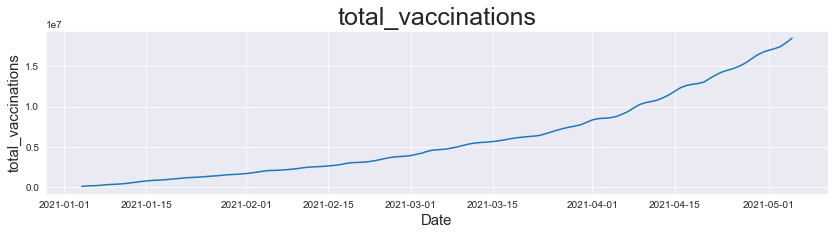

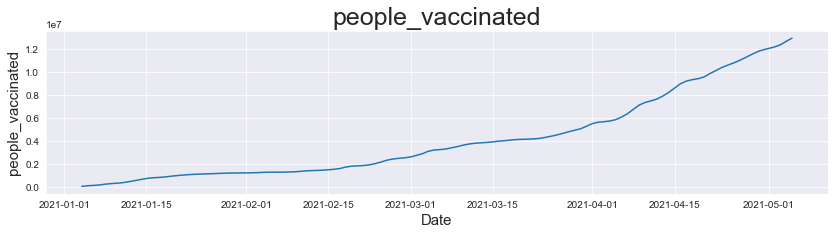

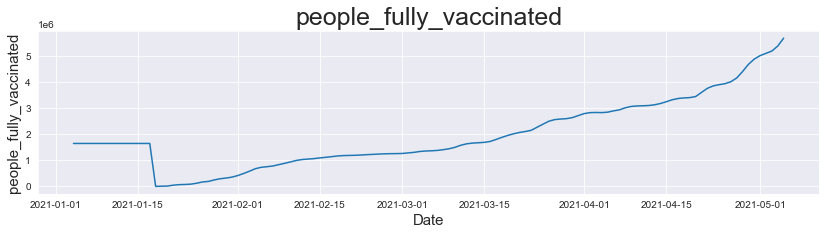

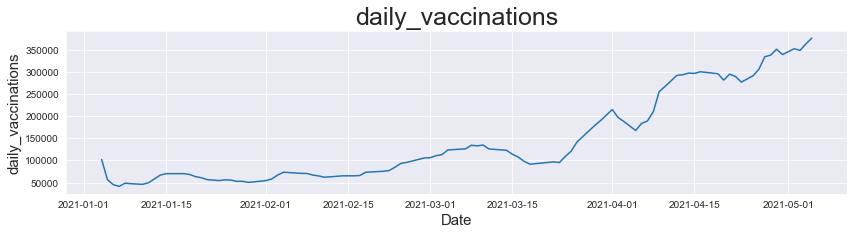

In [161]:
for i in var_Spain.columns.to_list():

    sns.set_style("darkgrid")
    plt.figure(figsize=(14, 3))
    sns.lineplot(data=vacc_Spain[i])
    #sns.lineplot(data = vacc_Spain['daily_vaccinations'])
    plt.title(i,fontsize=25)
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(i, fontsize=15)
    plt.show()

### Comprobación de la causalidad mediante la prueba de causalidad de Granger

La base de la autoregresión vectorial es que cada una de las series temporales del sistema se influye mutuamente. Es decir, se puede predecir la serie con valores pasados de ella misma junto con otras series del sistema.

Utilizando la prueba de causalidad de Granger, es posible comprobar esta relación incluso antes de construir el modelo.

Entonces, ¿qué prueba realmente la causalidad de Granger?

La causalidad de Granger comprueba la hipótesis nula de que los **coeficientes de los valores pasados en la ecuación de regresión son cero**.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [162]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(var_Spain, variables = var_Spain.columns) 

,total_vaccinations_x,people_vaccinated_x,people_fully_vaccinated_x,daily_vaccinations_x
total_vaccinations_y,1.0,0.0002,0.2094,0.0000
people_vaccinated_y,0.0,1.0000,0.0446,0.0000
people_fully_vaccinated_y,0.0,0.0000,1.0000,0.0397
daily_vaccinations_y,0.0,0.0000,0.0160,1.0000


Entonces, ¿cómo interpretar los p-values?

Si un valor p-value dado es < nivel de significación (0,05), entonces, la  serie X correspondiente (columna) provoca la serie Y (fila).

Por ejemplo, el p-value = 0.0160 indica que **'people_fully_vaccinated_x'** causa **'daily_vaccinations_y'**